In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt


# Define the different categories for each column
climates = ["present", "future"]
cpm_members = list(range(1, 13))  # 12 ensemble members (1-12)
gauge_locs = list(range(1, 51))  # 50 gauge locations (1-50)
durations = [1, 3, 6, 12, 24, 48]  # 6 durations
events = list(range(1, 21))  # 20 events (1-20)

# Create a cartesian product of all combinations
combinations = list(itertools.product(climates, cpm_members, gauge_locs, durations, events))

# Convert the list of tuples into a DataFrame
df_long = pd.DataFrame(combinations, columns=["Climate", "CPM", "Gauge_loc", "Duration_sample", "Event_num"])


# Set the random seed for reproducibility
np.random.seed(42)

# Number of rows in the dataframe
num_rows = df_long.shape[0]

# Generate random values for max_intensity between 20 and 100 (one decimal precision)
df_long['max_intensity'] = np.round(np.random.uniform(20, 100, num_rows), 1)

# Generate random values for total_volume between 25 and 200 (ensuring they are >= max_intensity)
df_long['total_volume'] = np.round(np.maximum(df_long['max_intensity'], np.random.uniform(25, 200, num_rows)), 1)

# Generate random values for event_duration between 1 and 72 (steps of 0.5)
df_long['event_duration'] = np.round(np.random.uniform(1, 72, num_rows) // 0.5 * 0.5, 1)


# Function to generate random dates between a given start and end date (without time info)
def generate_random_dates(start_date, end_date, size):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    random_dates = pd.to_datetime(np.random.uniform(start.value, end.value, size=size), unit='ns')
    return random_dates.normalize()  # Remove time, keep only the date

# Generate random dates for "present" climate (between 2000-01-01 and 2019-12-31)
present_dates = generate_random_dates("2000-01-01", "2019-12-31", df_long[df_long['Climate'] == 'present'].shape[0])

# Generate random dates for "future" climate (between 2080-01-01 and 2099-12-31)
future_dates = generate_random_dates("2080-01-01", "2099-12-31", df_long[df_long['Climate'] == 'future'].shape[0])

# Assign these dates back to the DataFrame
df_long.loc[df_long['Climate'] == 'present', 'date'] = present_dates
df_long.loc[df_long['Climate'] == 'future', 'date'] = future_dates

# Ensure 'date' column is in the correct date-only format
df_long['date'] = df_long['date'].dt.date


In [2]:

####################################################
####################################################
####################################################

def calculate_theta_R(dates):
    """
    Calculate theta (angle in radians) and R (resultant length) for a series of dates.

    Parameters:
    - dates: Pandas Series of datetime objects (e.g., dates of events)

    Returns:
    - theta: Numpy array of angles (in radians) for each date
    - R: The resultant length (measure of how clustered the dates are)
    """
    # Extract the day of the year from the provided dates (1-365/366)
    D = dates.dt.dayofyear

    # Convert the day of the year to an angle (theta) in radians
    theta = D * 2 * np.pi / 365.25

    # Calculate Cartesian coordinates (x, y) on the unit circle
    x = np.cos(theta)
    y = np.sin(theta)

    # Calculate the mean of x and y
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the resultant length R, which represents the dispersion
    R = np.sqrt(x_mean**2 + y_mean**2)

    # Return theta and the resultant length R
    return theta, R


# First, ensure the calculate_theta_R function is defined (from the previous step)

# Grouping the dataframe by 'Climate', 'Gauge_loc', and 'Duration_sample'
grouped = df_long.groupby(['Climate', 'Gauge_loc', 'Duration_sample'])

# Define a list to hold results
results = []

# Iterate through each group
for (climate, gauge, duration), group in grouped:
    
    # Ensure the 'date' column is in datetime format for the group
    group['date'] = pd.to_datetime(group['date'], errors='coerce')
    
    # Apply the calculate_theta_R function to the 'Date' column of the group
    theta, R = calculate_theta_R(group['date'])
    
    # Store the mean of theta and R in the results list for each group
    results.append({
        'Climate': climate,
        'Gauge_loc': gauge,
        'Duration_sample': duration,
        'theta_mean': np.mean(theta),  # Mean theta for the group
        'R': R  # Dispersion R for the group
    })

# Convert the results list into a DataFrame
df_theta_R = pd.DataFrame(results)


# Step 1: Group by 'Gauge_loc', 'Duration_sample', and 'Climate', calculating the mean theta and R
grouped = df_theta_R.groupby(['Gauge_loc', 'Duration_sample', 'Climate'])[['theta_mean', 'R']].mean().reset_index()

# Step 2: Pivot the data so we have separate columns for present and future climates
present = grouped[grouped['Climate'] == 'present'].set_index(['Gauge_loc', 'Duration_sample'])
future = grouped[grouped['Climate'] == 'future'].set_index(['Gauge_loc', 'Duration_sample'])

# Step 3: Merge the present and future DataFrames
merged = present.join(future, lsuffix='_present', rsuffix='_future')

# Step 4: Calculate differences
merged['theta_change'] = merged['theta_mean_future'] - merged['theta_mean_present']
merged['R_change'] = merged['R_future'] - merged['R_present']

# Step 5: Reset index to create a new DataFrame
df_changes = merged.reset_index()


###### Generate locations for gauges #############

import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Great Britain
gb_outline = gdf[(gdf.name == "United Kingdom")]

# Create a polygon from the geometry of Great Britain for point containment check
gb_polygon = gb_outline.geometry.values[0]

# Function to generate random points within the polygon
def generate_random_points_within_polygon(num_points, polygon):
    points = []
    while len(points) < num_points:
        # Generate a random point within the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        # Check if the point is within the polygon
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Set the number of gauge locations
num_gauges = 50

# Generate random latitude and longitude values for the gauge locations
random_points = generate_random_points_within_polygon(num_gauges, gb_polygon)

# Create a new DataFrame for gauge locations
gauge_locations = pd.DataFrame({
    'Gauge_loc': range(1, num_gauges + 1),
    'Latitude': [point.y for point in random_points],
    'Longitude': [point.x for point in random_points]
})

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

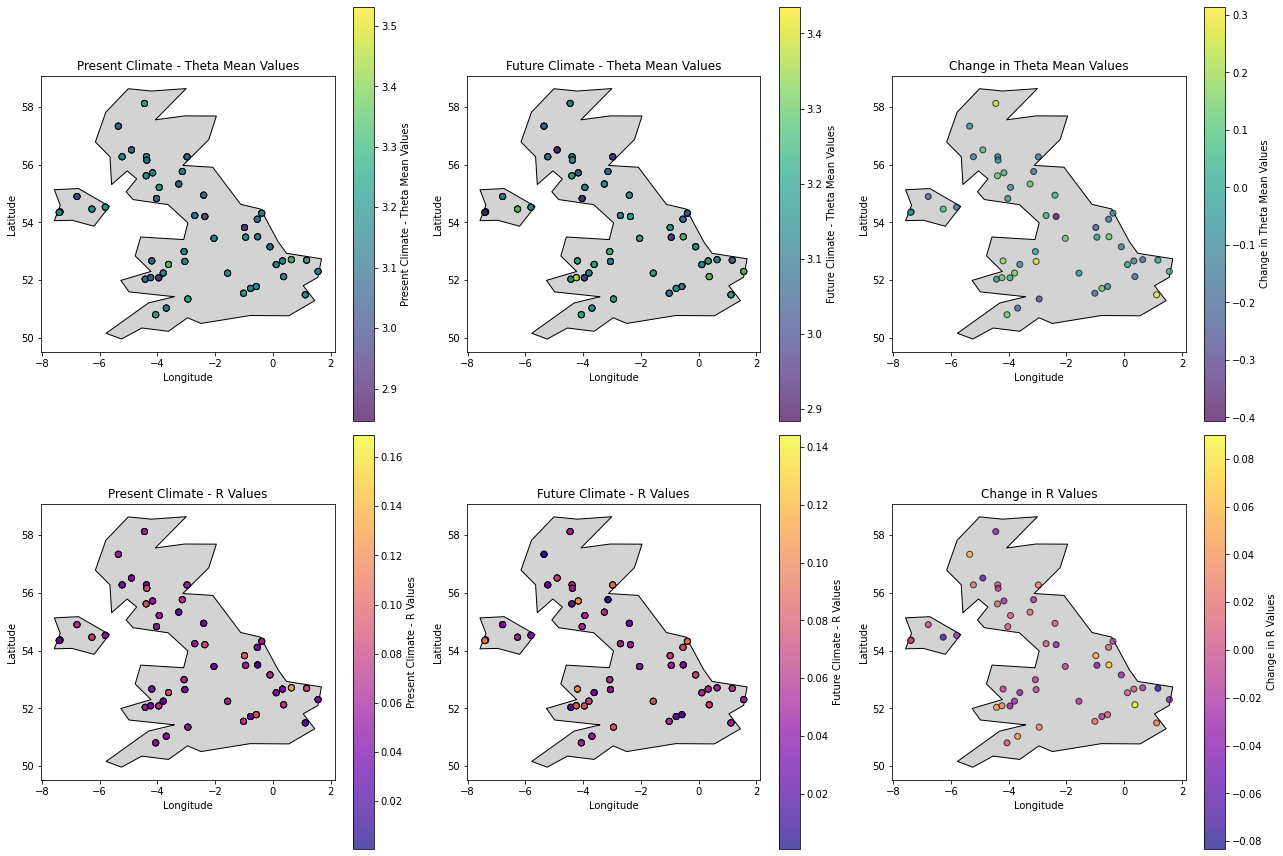

In [3]:



################################################################################################
### Plots of theta and R for present and future climates + the change  for a single duration ###
################################################################################################

# Function to plot values on a map
def plot_values_on_map(ax, data, title, gauge_locations, value_column, cmap='viridis'):
    """Plot values on a map for given data."""
    # Get longitude and latitude from gauge locations
    lon = gauge_locations.set_index('Gauge_loc').loc[data['Gauge_loc'], 'Longitude']
    lat = gauge_locations.set_index('Gauge_loc').loc[data['Gauge_loc'], 'Latitude']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for the specified value column
    scatter = ax.scatter(lon, lat, c=data[value_column], cmap=cmap, edgecolor='k', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add a color bar
    plt.colorbar(scatter, ax=ax, label=title)

# Load the outline of Great Britain
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gb_outline = gdf[(gdf.name == "United Kingdom")]

# Create a figure and axes for the six subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Present Climate - Theta Mean
present_theta_data = df_changes[['Gauge_loc', 'theta_mean_present']]
present_theta_data['Climate'] = 'present'  # Add a Climate column for clarity
plot_values_on_map(axes[0, 0], present_theta_data, 'Present Climate - Theta Mean Values', gauge_locations, 'theta_mean_present')

# Future Climate - Theta Mean
future_theta_data = df_changes[['Gauge_loc', 'theta_mean_future']]
future_theta_data['Climate'] = 'future'  # Add a Climate column for clarity
plot_values_on_map(axes[0, 1], future_theta_data, 'Future Climate - Theta Mean Values', gauge_locations, 'theta_mean_future')

# Change - Theta Mean
change_theta_data = df_changes[df_changes['Duration_sample'] == 1][['Gauge_loc', 'theta_change']]
change_theta_data['Climate'] = 'change'  # Add a Climate column for clarity
plot_values_on_map(axes[0, 2], change_theta_data, 'Change in Theta Mean Values', gauge_locations, 'theta_change')

# Present Climate - R
present_R_data = df_changes[['Gauge_loc', 'R_present']]
present_R_data['Climate'] = 'present'  # Add a Climate column for clarity
plot_values_on_map(axes[1, 0], present_R_data, 'Present Climate - R Values', gauge_locations, 'R_present', cmap='plasma')

# Future Climate - R
future_R_data = df_changes[['Gauge_loc', 'R_future']]
future_R_data['Climate'] = 'future'  # Add a Climate column for clarity
plot_values_on_map(axes[1, 1], future_R_data, 'Future Climate - R Values', gauge_locations, 'R_future', cmap='plasma')

# Change - R
change_R_data = df_changes[df_changes['Duration_sample'] == 1][['Gauge_loc', 'R_change']]
change_R_data['Climate'] = 'change'  # Add a Climate column for clarity
plot_values_on_map(axes[1, 2], change_R_data, 'Change in R Values', gauge_locations, 'R_change', cmap='plasma')

# Adjust layout
plt.tight_layout()

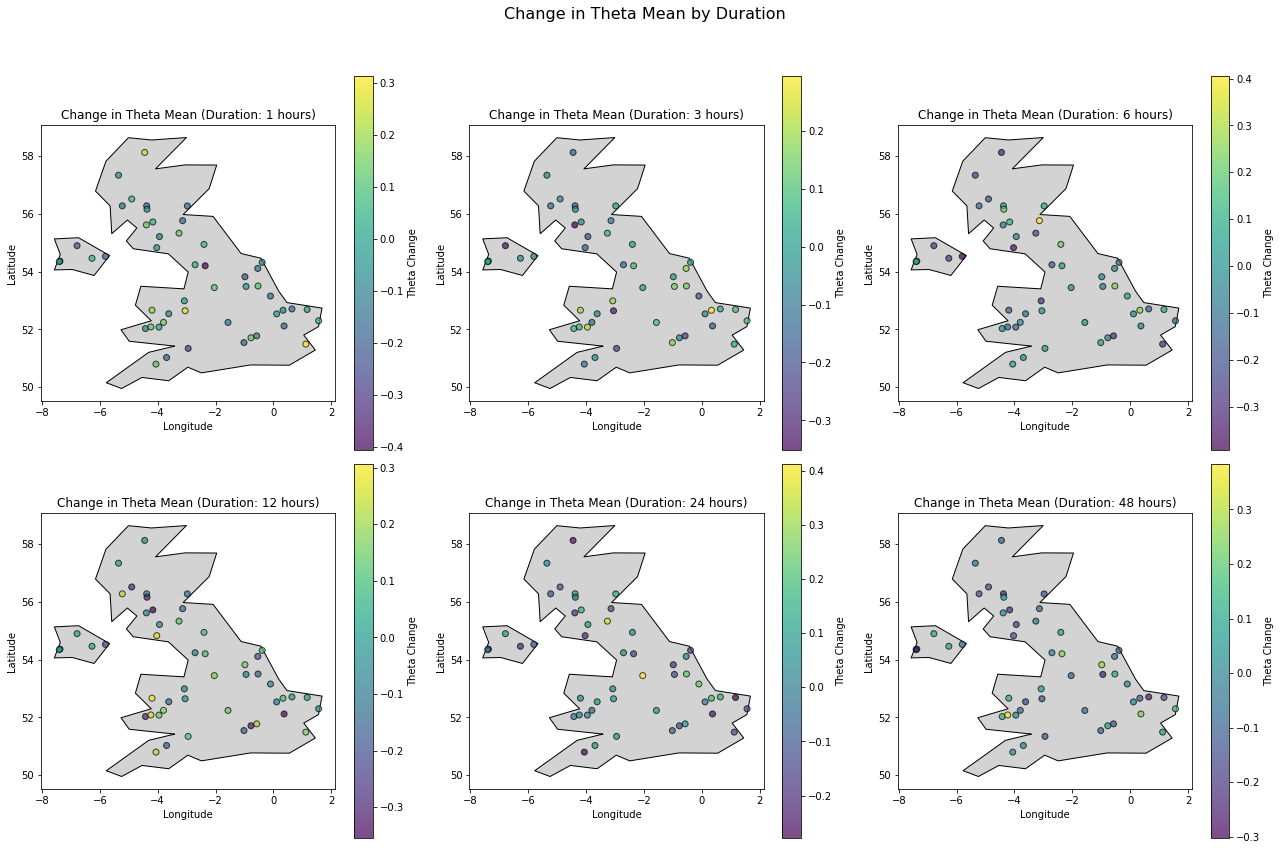

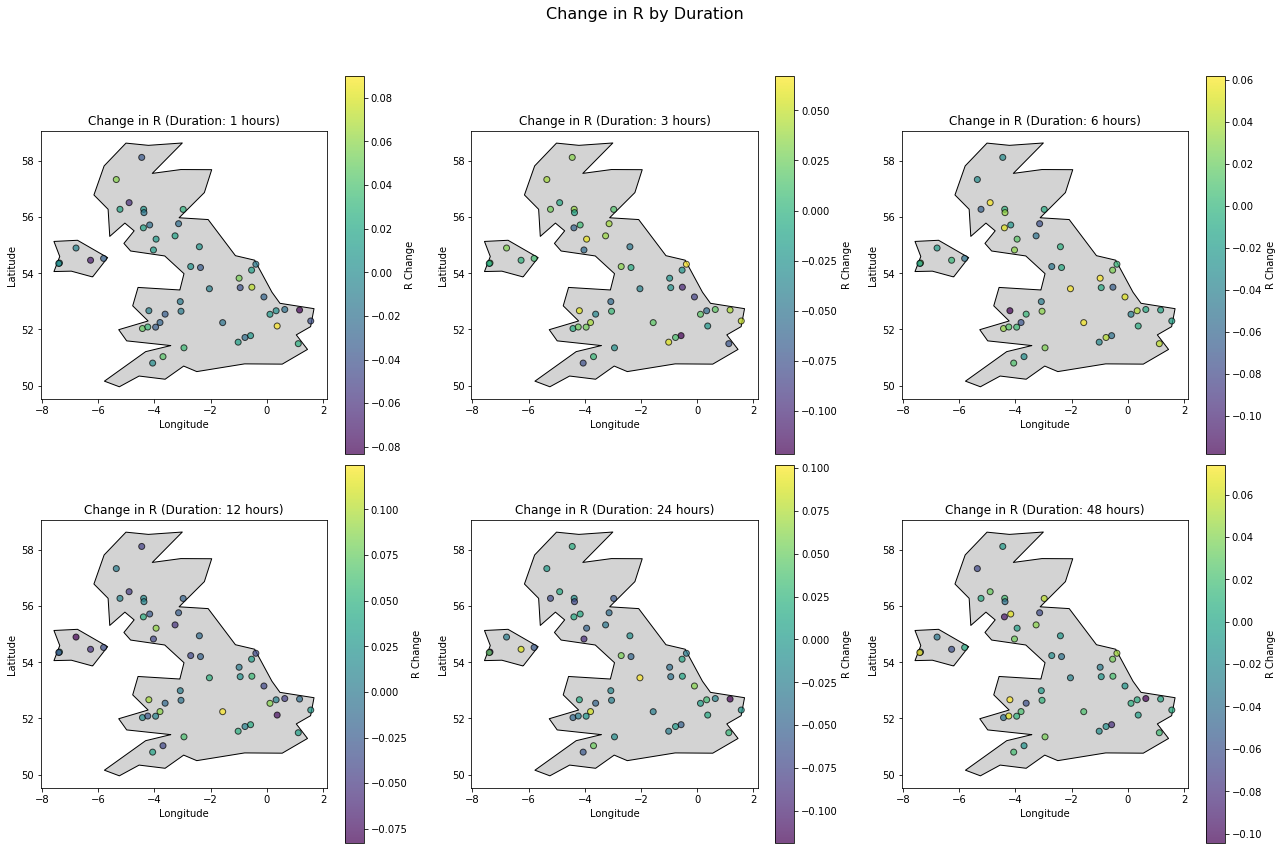

In [4]:
########################################################
### Plots of change of theta and R for each duration ###
########################################################

# Load the outline of Great Britain
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gb_outline = gdf[(gdf.name == "United Kingdom")]

# Define the unique durations to iterate over
durations = df_changes['Duration_sample'].unique()

# Function to plot the change in theta_mean for a given duration
def plot_change_theta_for_duration(ax, duration):
    # Filter the data for the given duration
    change_theta_data = df_changes[df_changes['Duration_sample'] == duration][['Gauge_loc', 'theta_change']]
    
    # Get longitude and latitude from gauge locations
    lon = gauge_locations.set_index('Gauge_loc').loc[change_theta_data['Gauge_loc'], 'Longitude']
    lat = gauge_locations.set_index('Gauge_loc').loc[change_theta_data['Gauge_loc'], 'Latitude']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for theta change
    scatter = ax.scatter(lon, lat, c=change_theta_data['theta_change'], cmap='viridis', edgecolor='k', alpha=0.7)
    ax.set_title(f'Change in Theta Mean (Duration: {duration} hours)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add a color bar
    plt.colorbar(scatter, ax=ax, label='Theta Change')

# Function to plot the change in R for a given duration
def plot_change_R_for_duration(ax, duration):
    # Filter the data for the given duration
    change_R_data = df_changes[df_changes['Duration_sample'] == duration][['Gauge_loc', 'R_change']]
    
    # Get longitude and latitude from gauge locations
    lon = gauge_locations.set_index('Gauge_loc').loc[change_R_data['Gauge_loc'], 'Longitude']
    lat = gauge_locations.set_index('Gauge_loc').loc[change_R_data['Gauge_loc'], 'Latitude']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for R change
    scatter = ax.scatter(lon, lat, c=change_R_data['R_change'], cmap='viridis', edgecolor='k', alpha=0.7)
    ax.set_title(f'Change in R (Duration: {duration} hours)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add a color bar
    plt.colorbar(scatter, ax=ax, label='R Change')

# Create a figure for theta_mean changes
fig_theta = plt.figure(figsize=(18, 12))
theta_axes = fig_theta.subplots(2, 3)

# Plot for each duration for theta
for i, duration in enumerate(durations):
    ax = theta_axes[i // 3, i % 3]  # Calculate row and column index
    plot_change_theta_for_duration(ax, duration)

# Adjust layout for theta figure
plt.tight_layout()
plt.suptitle('Change in Theta Mean by Duration', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

# Create a figure for R changes
fig_R = plt.figure(figsize=(18, 12))
R_axes = fig_R.subplots(2, 3)

# Plot for each duration for R
for i, duration in enumerate(durations):
    ax = R_axes[i // 3, i % 3]  # Calculate row and column index
    plot_change_R_for_duration(ax, duration)

# Adjust layout for R figure
plt.tight_layout()
plt.suptitle('Change in R by Duration', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

In [6]:
############################################################
### d_50 plots ########
############################################################

# Set the random seed for reproducibility
np.random.seed(42)

# Generate random values for d_50 between 0 and 1 (two decimal precision)
df_long['d_50'] = np.round(np.random.uniform(0, 1, df_long.shape[0]), 2)


# Generate random values for d_50 between 0 and 1 (two decimal precision)
df_long['d_50'] = np.round(np.random.uniform(0, 1, df_long.shape[0]), 2)

# Define a function to determine the season from a month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # September, October, November
        return 'Autumn'

# Create a new column for the month extracted from the date
df_long['month'] = pd.to_datetime(df_long['date']).dt.month

# Map each month to its respective season
df_long['season'] = df_long['month'].apply(get_season)

# Group by 'Climate', 'Gauge_loc', 'Duration_sample', and 'season', and calculate the mean of 'd_50'
df_d50_season_mean = df_long.groupby(['Climate', 'Gauge_loc', 'Duration_sample', 'season'], as_index=False)['d_50'].mean()



# Group by 'Climate', 'Gauge_loc', and 'Duration_sample', and calculate the mean of 'd_50'
df_d50_mean = df_long.groupby(['Climate', 'Gauge_loc', 'Duration_sample'], as_index=False)['d_50'].mean()

# Rename the column to 'd_50_mean'
df_d50_mean.rename(columns={'d_50': 'd_50_mean'}, inplace=True)


# Create a new DataFrame with the difference between present and future d_50 means
df_d50_difference = (
    df_d50_mean.pivot(index=['Gauge_loc', 'Duration_sample'], columns='Climate', values='d_50_mean')
    .reset_index()
)

# Calculate the difference
df_d50_difference['d_50_difference'] = df_d50_difference['future'] - df_d50_difference['present']


# I wanted plots to explore:
# How does d_50 change?
# - UK gauge dot plot of change to "mean d_50" for each (6) duration (so a subplot with six maps)
# How does d_50 change by season?
# - Change of "mean d_50" for each season for each duration (4x6 subplot)
